In [3]:
import os
import cv2
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
from pathlib import Path
import glob
import scipy
tf.random.set_seed(23)


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array

from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Dense,Input,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
from tensorflow.keras.layers import Flatten,Activation,Dropout,Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [5]:
data_dir = 'C:/Users/rupin/OneDrive/Desktop/Data mining/Assignment-1/images'
print(os.listdir(data_dir))
train = os.listdir(data_dir + "/train/")
valid = os.listdir(data_dir + "/validation/")
print(f'Train Classes - {train}')
print(f'Validation Classes - {valid}')

['train', 'validation']
Train Classes - ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Validation Classes - ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [6]:
train_dir='C:/Users/rupin/OneDrive/Desktop/Data mining/Assignment-1/images/train/'
test_dir='C:/Users/rupin/OneDrive/Desktop/Data mining/Assignment-1/images/validation'

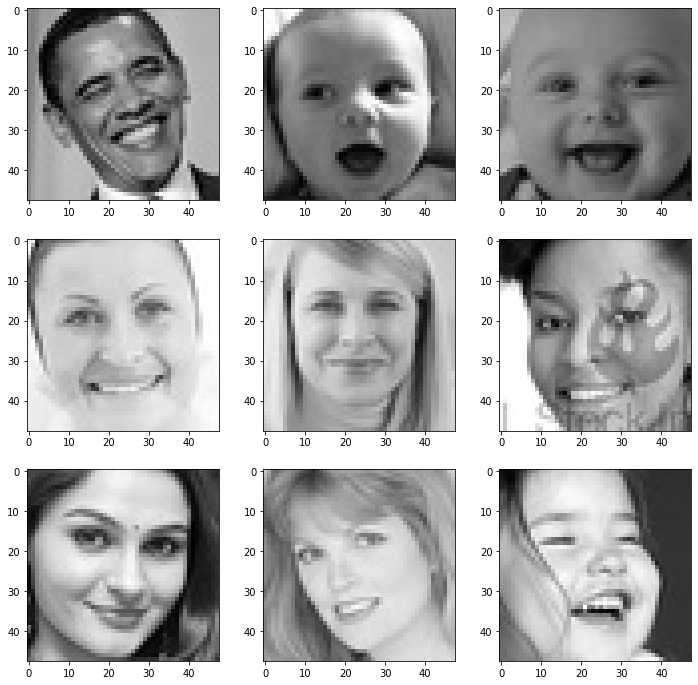

In [7]:
picture_size=48
expression = 'happy'

plt.figure(figsize= (12,12))
for i in range(1, 10, 1):
    plt.subplot(3,3,i)
    img = load_img(train_dir+expression+"/"+
                  os.listdir(train_dir+ expression)[i], target_size=(picture_size, picture_size))
    plt.imshow(img)   
plt.show()

In [8]:
def create_dataset_df(main_path, dataset_name):
    print(f"{dataset_name} is creating ...")
    df = {"img_path":[],"class_names":[]}
    for class_names in os.listdir(main_path):
            for img_path in glob.glob(f"{main_path}/{class_names}/*"):
                df["img_path"].append(img_path)
                df["class_names"].append(class_names)
    df = pd.DataFrame(df)
    print(f"{dataset_name} is created !")
    return df

In [9]:
train_df = create_dataset_df(train_dir, "Train dataset")

Train dataset is creating ...
Train dataset is created !


In [10]:
valid_df=create_dataset_df(test_dir, "Validation dataset")

Validation dataset is creating ...
Validation dataset is created !


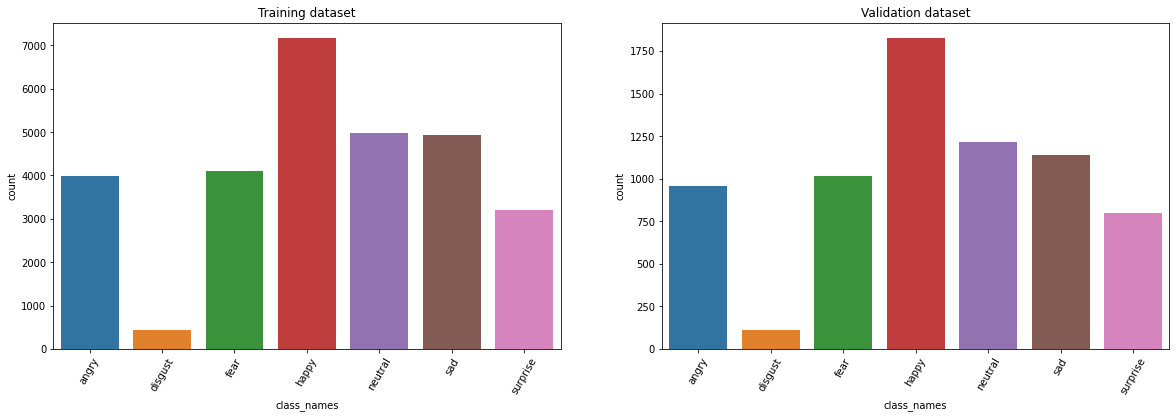

In [11]:
plt.figure(figsize=(20,6))
# train dataset
plt.subplot(1,2,1)
sns.countplot(data=train_df.sort_values("class_names"),x="class_names")
plt.title("Training dataset")
plt.xticks(rotation = 60)
# validation dataset
plt.subplot(1,2,2)
sns.countplot(data=valid_df.sort_values("class_names"),x="class_names")
plt.title("Validation dataset")
plt.xticks(rotation = 60)

plt.show()

In [12]:
train_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.2)
train_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    batch_size=128,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle='true')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(
    test_dir,
    target_size=(48, 48),
    batch_size=128,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle='false'
    )

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [13]:
no_of_classes=7
model=Sequential()
#adding first cnn layer
model.add(Conv2D(64,(3,3),padding='same',input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
#adding second cnn layer
model.add(Conv2D(128,(5,5),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))



In [47]:

model.add(Dense(no_of_classes, activation='softmax'))

opt=Adam(lr=0.0001)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_8 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_8 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 128)      

In [14]:
#Fit the model

from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

c=ModelCheckpoint("./model.h5",monitor='val_acc',verbose=1,save_best_only=True)

e=EarlyStopping(monitor='val_loss',min_delta=0,patience=3,verbose=1,restore_best_weights=True)

reduce_lr=ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=3,verbose=1,min_delta=0.0001)
callbacks_list=[e,c,reduce_lr]

model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.001),metrics=['accuracy'])

In [49]:
t=train_set.n//train_set.batch_size #no. of batches in training set
v=test_set.n//test_set.batch_size #no. of batches in validation set

history = model.fit_generator(generator=train_set,
                                steps_per_epoch=t,
                                epochs=50,
                                validation_data = test_set,
                                validation_steps = v,
                                callbacks=callbacks_list
                                )
#history=model.fit(train_set,epochs=60,validation_data=test_set)

C:\Users\rupin\AppData\Local\Temp\ipykernel_17264\85046662.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_set,


Epoch 1/50
225/225 [==============================] - ETA: 0s - loss: 1.6846 - accuracy: 0.3540WARNING:tensorflow:Can save best model only with val_acc available, skipping.


225/225 [==============================] - 487s 2s/step - loss: 1.6846 - accuracy: 0.3540 - val_loss: 1.7808 - val_accuracy: 0.2709 - lr: 0.0010
Epoch 2/50
225/225 [==============================] - ETA: 0s - loss: 1.3834 - accuracy: 0.4698WARNING:tensorflow:Can save best model only with val_acc available, skipping.


225/225 [==============================] - 241s 1s/step - loss: 1.3834 - accuracy: 0.4698 - val_loss: 1.5550 - val_accuracy: 0.3879 - lr: 0.0010
Epoch 3/50
225/225 [==============================] - ETA: 0s - loss: 1.2354 - accuracy: 0.5294WARNING:tensorflow:Can save best model only with val_acc available, skipping.


225/225 [==============================] - 249s 1s/step - loss: 1.2354 - accuracy: 0.5294 - val_loss: 1.3571 - val_accuracy: 0.4882 - lr: 0.0010
Epoch 4/50
225/225 [==============================] - ETA: 0s - loss: 1.1315 - accuracy: 0.5691WARNING:tensorflow:Can save best model only with val_acc available, skipping.


225/225 [==============================] - 263s 1s/step - loss: 1.1315 - accuracy: 0.5691 - val_loss: 1.3667 - val_accuracy: 0.4939 - lr: 0.0010
Epoch 5/50
225/225 [==============================] - ETA: 0s - loss: 1.0400 - accuracy: 0.6096WARNING:tensorflow:Can save best model only with val_acc available, skipping.


225/225 [==============================] - 268s 1s/step - loss: 1.0400 - accuracy: 0.6096 - val_loss: 1.5015 - val_accuracy: 0.4778 - lr: 0.0010
Epoch 6/50
225/225 [==============================] - ETA: 0s - loss: 0.9535 - accuracy: 0.6419WARNING:tensorflow:Can save best model only with val_acc available, skipping.


225/225 [==============================] - 275s 1s/step - loss: 0.9535 - accuracy: 0.6419 - val_loss: 1.1886 - val_accuracy: 0.5604 - lr: 0.0010
Epoch 7/50
225/225 [==============================] - ETA: 0s - loss: 0.8681 - accuracy: 0.6766WARNING:tensorflow:Can save best model only with val_acc available, skipping.


225/225 [==============================] - 311s 1s/step - loss: 0.8681 - accuracy: 0.6766 - val_loss: 1.2811 - val_accuracy: 0.5342 - lr: 0.0010
Epoch 8/50
225/225 [==============================] - ETA: 0s - loss: 0.7788 - accuracy: 0.7106WARNING:tensorflow:Can save best model only with val_acc available, skipping.


225/225 [==============================] - 285s 1s/step - loss: 0.7788 - accuracy: 0.7106 - val_loss: 1.2897 - val_accuracy: 0.5474 - lr: 0.0010
Epoch 9/50
225/225 [==============================] - ETA: 0s - loss: 0.6922 - accuracy: 0.7463Restoring model weights from the end of the best epoch: 6.



Epoch 9: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
225/225 [==============================] - 280s 1s/step - loss: 0.6922 - accuracy: 0.7463 - val_loss: 1.5111 - val_accuracy: 0.4805 - lr: 0.0010
Epoch 9: early stopping


In [15]:
model.save_weights('face_emotion_model.h5')

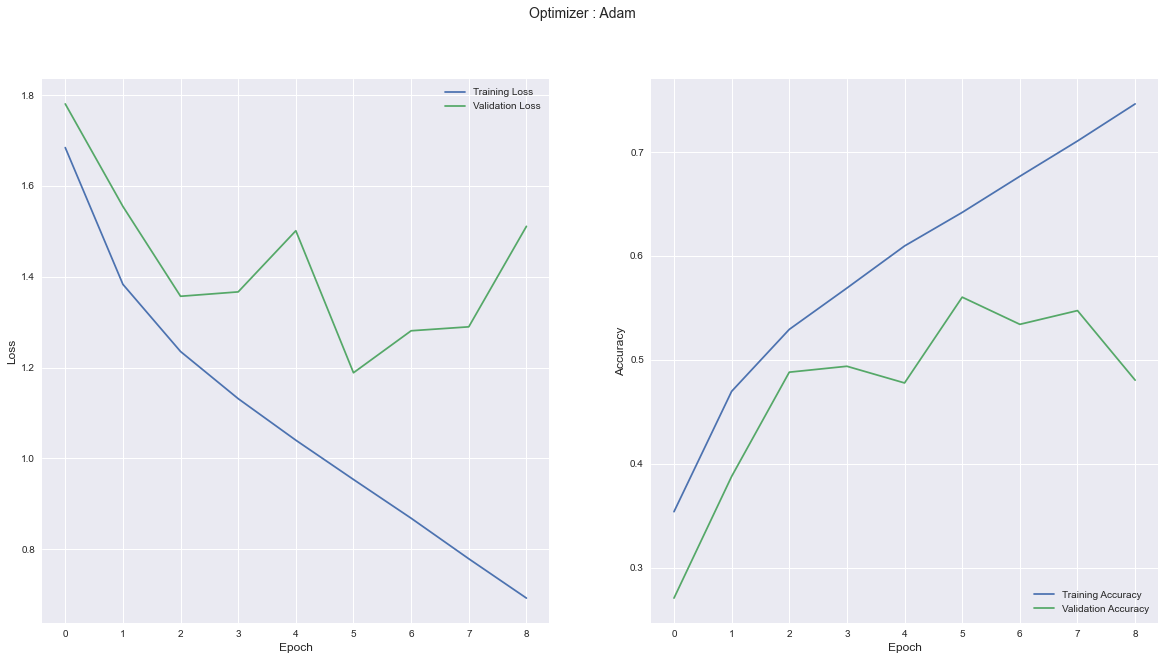

In [57]:
plt.style.use('seaborn')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.suptitle('Optimizer : Adam', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc='lower right')
plt.show()


In [17]:

class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
train_set.reset()
y_pred = model.predict(train_set)
y_true = train_set.classes

for i in range(len(class_names)):
    idx = y_true == i
    class_acc = sum(y_true[idx] == y_pred[idx].argmax(axis=1)) / sum(idx)
    print(class_names[i], 'accuracy:', class_acc)

226/226 [==============================] - 126s 559ms/step
Angry accuracy: 0.0005008765339343851
Disgust accuracy: 0.0
Fear accuracy: 0.0
Happy accuracy: 0.0
Neutral accuracy: 0.0
Sad accuracy: 0.0
Surprise accuracy: 0.0
